In [1]:
import ast
import pathlib
import sys

import numpy as np
import pandas as pd
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

import matplotlib.pyplot as plt
import seaborn as sns
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)
from sklearn.metrics import precision_recall_curve

sys.path.append("../../..")
import argparse

In [2]:
# # set up the parser
# parser = argparse.ArgumentParser(description="Train MLP model")

# # add arguments to parser
# parser.add_argument(
#     "--CELL_TYPE",
#     type=str,
#     default="all",
#     help="Cell type to train model on. Default is all",
# )

# parser.add_argument(
#     "--MODEL_NAME",
#     type=str,
#     default="MLP",
#     help="Model name to train. Default is MLP",
# )

# parser.add_argument(
#     "--SHUFFLE",
#     type=str,
#     default="False",
#     help="Shuffle data before training. Default is False",
# )

# # parse the arguments
# args = parser.parse_args()

# CELL_TYPE = args.CELL_TYPE
# MODEL_NAME = args.MODEL_NAME
# SHUFFLE = args.SHUFFLE
# SHUFFLE = ast.literal_eval(SHUFFLE)
# print(CELL_TYPE, MODEL_NAME, SHUFFLE)

In [3]:
CELL_TYPE = "SHSY5Y"
MODEL_NAME = "MultiClass_MLP"
SHUFFLE = False

In [4]:
ml_configs_file = pathlib.Path("../../MLP_utils/multi_class_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME

mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

# load in the class weights
class_weights_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/class_weights/{CELL_TYPE}/multi_class/class_weights.txt"
).resolve(strict=True)
# read the class weights into a list for use in the loss function as a list
class_weights = []
with open(class_weights_file_path, "r") as f:
    for line in f:
        class_weights.append(float(line.strip()))
# check the class weights are correct
print(class_weights)

[0.954878893196544, 0.505315252332322, 0.539805854471134]


In [5]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df1 = pd.read_parquet(file_path)

In [6]:
# get paths for toml files
ground_truth_file_path = pathlib.Path(f"../../MLP_utils/ground_truth.toml").resolve(
    strict=True
)
treatment_splits_file_path = pathlib.Path(f"../../MLP_utils/splits.toml").resolve(
    strict=True
)
# read toml files
ground_truth = toml.load(ground_truth_file_path)
treatment_splits = toml.load(treatment_splits_file_path)

In [7]:
# get information from toml files
apoptosis_groups_list = ground_truth["Apoptosis"]["apoptosis_groups_list"]
pyroptosis_groups_list = ground_truth["Pyroptosis"]["pyroptosis_groups_list"]
healthy_groups_list = ground_truth["Healthy"]["healthy_groups_list"]

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [8]:
np.random.seed(0)
if ast.literal_eval(mlp_params.DATA_SUBSET_OPTION):
    df1 = df1.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose").apply(
        lambda x: x.sample(n=mlp_params.DATA_SUBSET_NUMBER, random_state=0)
    )
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER} per treatment group")
    print(df1.shape)
    df1.reset_index(drop=True, inplace=True)
else:
    print("Data Subset Is Off")

Data Subset Is Off


In [9]:
# add apoptosis, pyroptosis and healthy columns to dataframe
df1["apoptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in apoptosis_groups_list,
    axis=1,
)
df1["pyroptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in pyroptosis_groups_list,
    axis=1,
)
df1["healthy"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in healthy_groups_list,
    axis=1,
)

# merge apoptosis, pyroptosis, and healthy columns into one column
df1["labels"] = df1.apply(
    lambda row: "apoptosis"
    if row["apoptosis"]
    else "pyroptosis"
    if row["pyroptosis"]
    else "healthy",
    axis=1,
)
# # drop apoptosis, pyroptosis, and healthy columns
df1.drop(columns=["apoptosis", "pyroptosis", "healthy"], inplace=True)

In [10]:
# set path for index file
index_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/indexes/{params.CELL_TYPE}/multi_class/{params.MODEL_NAME}_data_split_indexes.tsv"
).resolve(strict=True)

# read index file
index_df = pd.read_csv(index_file_path, sep="\t")
index_df.head()

,labeled_data_index,label
0,248522,train
1,478672,train
2,265238,train
3,384826,train
4,31898,train


In [11]:
# get train, validation, test, and holdout indexes
train_indexes = index_df.loc[index_df["label"] == "train"]["labeled_data_index"]
val_indexes = index_df.loc[index_df["label"] == "val"]["labeled_data_index"]
test_indexes = index_df.loc[index_df["label"] == "test"]["labeled_data_index"]
treatment_holdout = index_df.loc[index_df["label"] == "treatment_holdout"][
    "labeled_data_index"
]
holdout_indexes = index_df.loc[index_df["label"] == "holdout"]["labeled_data_index"]
print(
    train_indexes.shape,
    val_indexes.shape,
    test_indexes.shape,
    treatment_holdout,
    holdout_indexes.shape,
)

assert (
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + treatment_holdout.shape[0]
    + holdout_indexes.shape[0]
) == index_df.shape[0]

(152275,) (38069,) (202050,) 392394     93196
392395     93197
392396     93198
392397     93199
392398     93200
           ...  
446996    594342
446997    594343
446998    594344
446999    594345
447000    594346
Name: labeled_data_index, Length: 54607, dtype: int64 (150901,)


In [12]:
treatment_holdout.head()

392394    93196
392395    93197
392396    93198
392397    93199
392398    93200
Name: labeled_data_index, dtype: int64

In [13]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df1.columns[df1.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df1[df_metadata]
df_descriptive["labels"] = df1["labels"]
df_values = df1.drop(columns=df_metadata)

/tmp/ipykernel_2020721/2522821119.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descriptive["labels"] = df1["labels"]


In [14]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["new_labels"] = le.fit_transform(df_values["labels"])
# get mini dataframe that contains the decoder
df_labels = df_values[["labels", "new_labels"]]
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "labels",
        "new_labels",
    ],
    axis=1,
)
df_values_Y = df_values["new_labels"]
df_values_Y.unique()
df_labels.drop_duplicates(inplace=True)
# pandas chaining to reset index and drop old index
df_labels.reset_index(drop=True, inplace=True)

/tmp/ipykernel_2020721/2910622580.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels.drop_duplicates(inplace=True)


In [15]:
print(
    train_indexes.shape,
    val_indexes.shape,
    test_indexes.shape,
    treatment_holdout,
    holdout_indexes.shape,
)
print(
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + treatment_holdout.shape[0]
    + holdout_indexes.shape[0]
)

(152275,) (38069,) (202050,) 392394     93196
392395     93197
392396     93198
392397     93199
392398     93200
           ...  
446996    594342
446997    594343
446998    594344
446999    594345
447000    594346
Name: labeled_data_index, Length: 54607, dtype: int64 (150901,)
597902


In [16]:
# get the train, validation, test, and holdout dataframes from the indexes
X_train = df_values_X.iloc[train_indexes.values]
X_val = df_values_X.iloc[val_indexes.values]
X_test = df_values_X.iloc[test_indexes.values]
X_treatment_holdout = df_values_X.iloc[treatment_holdout.values]
X_holdout = df_values_X.iloc[holdout_indexes.values]

Y_train = df_values_Y.iloc[train_indexes.values]
Y_val = df_values_Y.iloc[val_indexes.values]
Y_test = df_values_Y.iloc[test_indexes.values]
Y_treatment_holdout = df_values_Y.iloc[treatment_holdout.values]
Y_holdout = df_values_Y.iloc[holdout_indexes.values]

metadata_train = df_descriptive.iloc[train_indexes.values]
metadata_val = df_descriptive.iloc[val_indexes.values]
metadata_test = df_descriptive.iloc[test_indexes.values]
metadata_treatment_holdout = df_descriptive.iloc[treatment_holdout.values]
metadata_holdout = df_descriptive.iloc[holdout_indexes.values]

In [17]:
print(
    Y_train[Y_train == 0].shape,
    Y_train[Y_train == 1].shape,
    Y_train[Y_train == 2].shape,
)
print(Y_val[Y_val == 0].shape, Y_val[Y_val == 1].shape, Y_val[Y_val == 2].shape)
print(Y_test[Y_test == 0].shape, Y_test[Y_test == 1].shape, Y_test[Y_test == 2].shape)
print(
    Y_treatment_holdout[Y_treatment_holdout == 0].shape,
    Y_treatment_holdout[Y_treatment_holdout == 1].shape,
    Y_treatment_holdout[Y_treatment_holdout == 2].shape,
)
print(
    Y_holdout[Y_holdout == 0].shape,
    Y_holdout[Y_holdout == 1].shape,
    Y_holdout[Y_holdout == 2].shape,
)

(7972,) (89086,) (55217,)
(1993,) (22273,) (13803,)
(9965,) (111360,) (80725,)
(0,) (0,) (54607,)
(7048,) (73054,) (70799,)


In [18]:
# reset indexes for all dataframes
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_treatment_holdout.reset_index(drop=True, inplace=True)
X_holdout.reset_index(drop=True, inplace=True)

Y_train.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
Y_treatment_holdout.reset_index(drop=True, inplace=True)
Y_holdout.reset_index(drop=True, inplace=True)

In [19]:
print(
    X_train.shape, X_val.shape, X_test.shape, X_treatment_holdout.shape, X_holdout.shape
)
print(
    Y_train.shape, Y_val.shape, Y_test.shape, Y_treatment_holdout.shape, Y_holdout.shape
)

(152275, 1251) (38069, 1251) (202050, 1251) (54607, 1251) (150901, 1251)
(152275,) (38069,) (202050,) (54607,) (150901,)


#### Shuffle Data


In [20]:
np.random.seed(0)

if SHUFFLE:
    print("Shuffling Data")
    for column in X_train.columns:
        X_train[column] = np.random.permutation(X_train[column].values)

#### Split Data - All Models can proceed through this point

In [21]:
mlp_params.OUT_FEATURES = Y_train.unique().shape[0]
print(mlp_params.OUT_FEATURES)

3


In [22]:
Y_train = torch.tensor(Y_train.values)
Y_train = torch.nn.functional.one_hot(
    Y_train, num_classes=mlp_params.OUT_FEATURES
).float()

Y_val = torch.tensor(Y_val.values)
Y_val = torch.nn.functional.one_hot(Y_val, num_classes=mlp_params.OUT_FEATURES).float()

Y_test = torch.tensor(Y_test.values)
Y_test = torch.nn.functional.one_hot(
    Y_test, num_classes=mlp_params.OUT_FEATURES
).float()

Y_holdout = torch.tensor(Y_holdout.values)
Y_holdout = torch.nn.functional.one_hot(
    Y_holdout, num_classes=mlp_params.OUT_FEATURES
).float()

Y_treatment_holdout = torch.tensor(Y_treatment_holdout.values)
Y_treatment_holdout = torch.nn.functional.one_hot(
    Y_treatment_holdout, num_classes=mlp_params.OUT_FEATURES
).float()

# convert the X dataframes to tensors
X_train = torch.tensor(X_train.values)
X_val = torch.tensor(X_val.values)
X_test = torch.tensor(X_test.values)
X_holdout = torch.tensor(X_holdout.values)
X_treatment_holdout = torch.tensor(X_treatment_holdout.values)

In [23]:
# produce data objects for train, val and test datasets
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
val_data = torch.utils.data.TensorDataset(X_val, Y_val)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

In [24]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(df_values["labels"].unique())

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  3
Multi_Class


In [25]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=False
)

In [26]:
# call the optimized training model
(
    train_loss,
    train_acc,
    valid_loss,
    valid_acc,
    epochs_ran,
    model,
) = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
    class_weights=class_weights,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.317362).  Saving model ...
	 Train_Loss: 0.3488 Train_Acc: 0.001 Val_Loss: 0.3174  BEST VAL Loss: 0.3174  Val_Acc: 0.000

Epoch 1: Validation loss decreased (0.317362 --> 0.310626).  Saving model ...
	 Train_Loss: 0.3312 Train_Acc: 0.001 Val_Loss: 0.3106  BEST VAL Loss: 0.3106  Val_Acc: 0.000

Epoch 2: Validation loss decreased (0.310626 --> 0.305099).  Saving model ...
	 Train_Loss: 0.3213 Train_Acc: 0.001 Val_Loss: 0.3051  BEST VAL Loss: 0.3051  Val_Acc: 0.000

Epoch 3: Validation loss decreased (0.305099 --> 0.302543).  Saving model ...
	 Train_Loss: 0.3144 Train_Acc: 0.001 Val_Loss: 0.3025  BEST VAL Loss: 0.3025  Val_Acc: 0.000

Epoch 4: Validation loss decreased (0.302543 --> 0.299228).  Saving model ...
	 Train_Loss: 0.3091 Train_Acc: 0.001 Val_Loss: 0.2992  BEST VAL Loss: 0.2992  Val_Acc: 0.000

Epoch 5: Validation loss decreased (0.299228 --> 0.297294).  Saving model ...
	 Train_Loss: 0.3047 Train_Acc: 0.001 Val_Loss: 0.2973  BE

In [27]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "label",
        "metric",
        "value",
        "group",
        "shuffled_data",
    ]
)
# check empty dataframe
model_stats_df

,label,metric,value,group,shuffled_data


/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1018: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1019: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


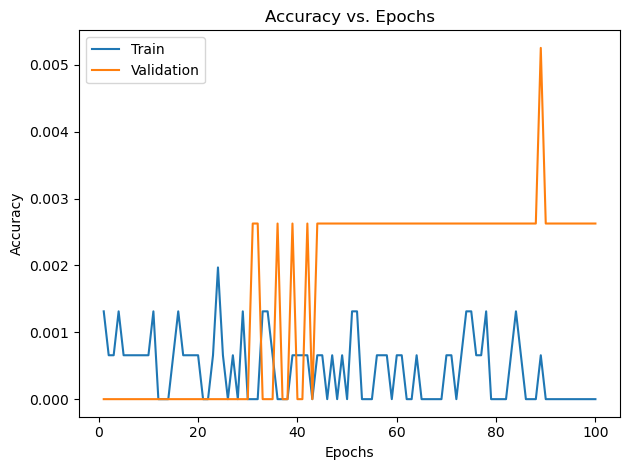

In [28]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1018: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1019: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


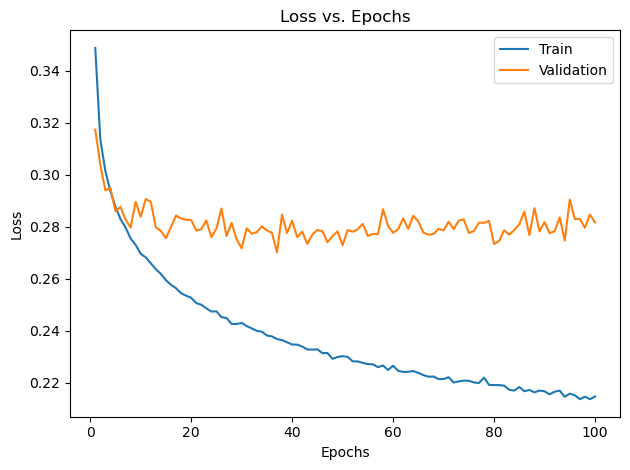

In [29]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

### Test Models on training data

In [30]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    (y_pred_list, y_pred_prob_list, Y_test_list,) = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [31]:
# convert output tensors into arrays

# list of tensors to list of lists
y_pred_prob_list = [tensor.tolist() for tensor in y_pred_prob_list]
Y_test_list = [tensor.tolist() for tensor in Y_test_list]
# completly flatten list of lists
new_prob_list = []
for i in y_pred_prob_list:
    for j in i:
        new_prob_list.append(j)

new_y_test_list = []
for i in Y_test_list:
    for j in i:
        new_y_test_list.append(j)

# list of lists to array
y_pred_prob_list = np.array(new_prob_list)
Y_test = np.array(new_y_test_list)

In [32]:
# get the PR curve for each class
pr_curve_0 = precision_recall_curve(Y_test[:, 0], y_pred_prob_list[:, 0])
pr_curve_1 = precision_recall_curve(Y_test[:, 1], y_pred_prob_list[:, 1])
pr_curve_2 = precision_recall_curve(Y_test[:, 2], y_pred_prob_list[:, 2])

In [33]:
# make a dataframe of the precision-recall curves for each class
pr_curve_0 = pd.DataFrame(
    zip(pr_curve_0[0], pr_curve_0[1]),
    columns=["precision", "recall"],
)
pr_curve_0["label"] = 0

pr_curve_1 = pd.DataFrame(
    zip(pr_curve_1[0], pr_curve_1[1]),
    columns=["precision", "recall"],
)
pr_curve_1["label"] = 1

pr_curve_2 = pd.DataFrame(
    zip(pr_curve_2[0], pr_curve_2[1]),
    columns=["precision", "recall"],
)
pr_curve_2["label"] = 2

# make the precision-recall curve dataframe
pr_curve_df = pd.DataFrame(columns=["precision", "recall", "label"])
# concatenate the dataframes together
pr_curve_df = pd.concat([pr_curve_df, pr_curve_0, pr_curve_1, pr_curve_2])

# get the decoded labels
tmp_df = df_values[["new_labels", "labels"]]
# get the unique rows
tmp_df.drop_duplicates(inplace=True)
# make a dict of the labels and new labels
label_dict = dict(zip(tmp_df["new_labels"], tmp_df["labels"]))

# change the label column to the actual labels from the label dict
pr_curve_df["label"] = pr_curve_df["label"].map(label_dict)
pr_curve_df["data_split"] = "train"
pr_curve_df["shuffle"] = mlp_params.SHUFFLE

/tmp/ipykernel_2020721/4273854277.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop_duplicates(inplace=True)


In [34]:
main_prob_df = pd.DataFrame(
    columns=[
        "class_0_prob",
        "class_1_prob",
        "class_2_prob",
        "label_true",
        "label_pred",
        "data_split",
        "shuffle",
        "class_name",
    ]
)

In [35]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["class_0_prob", "class_1_prob", "class_2_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "train"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)

main_prob_df = pd.concat([main_prob_df, prob_df])

In [36]:
# create a master dataframe to store all the model stats
# across all data splits and shuffled data
pr_curve_df_all = pd.DataFrame(
    columns=["precision", "recall", "label", "data_split", "shuffle"]
)
pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)

In [37]:
pr_curve_df_all["data_split"].unique()

array(['train'], dtype=object)

In [38]:
# prior to using the output_stats function, the y_pred_list and Y_test_list must be converted to a single list each
# Y_test_list de code the one hot encoding
Y_test_list = [np.argmax(i) for i in Y_test]

In [39]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["class_0_prob", "class_1_prob", "class_2_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "train"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)

main_prob_df = pd.concat([main_prob_df, prob_df])

/tmp/ipykernel_2020721/1198269099.py:23: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  main_prob_df = pd.concat([main_prob_df, prob_df])


In [40]:
stats_df = output_stats(
    y_pred_list,
    Y_test_list,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      7972
           1       0.81      0.97      0.88     89086
           2       0.93      0.65      0.77     55217

    accuracy                           0.85    152275
   macro avg       0.91      0.85      0.87    152275
weighted avg       0.87      0.85      0.85    152275



/tmp/ipykernel_2020721/3777910350.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [41]:
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE
stats_df
model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

## Test models on Validation data

In [42]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    (y_pred_list, y_pred_prob_list, Y_test_list) = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [43]:
# convert output tensors into arrays

# list of tensors to list of lists
y_pred_prob_list = [tensor.tolist() for tensor in y_pred_prob_list]
Y_test_list = [tensor.tolist() for tensor in Y_test_list]
# completly flatten list of lists
new_prob_list = []
for i in y_pred_prob_list:
    for j in i:
        new_prob_list.append(j)

new_y_test_list = []
for i in Y_test_list:
    for j in i:
        new_y_test_list.append(j)

# list of lists to array
y_pred_prob_list = np.array(new_prob_list)
Y_test = np.array(new_y_test_list)

In [44]:
# get the PR curve for each class
pr_curve_0 = precision_recall_curve(Y_test[:, 0], y_pred_prob_list[:, 0])
pr_curve_1 = precision_recall_curve(Y_test[:, 1], y_pred_prob_list[:, 1])
pr_curve_2 = precision_recall_curve(Y_test[:, 2], y_pred_prob_list[:, 2])

In [45]:
# make a dataframe of the precision-recall curves for each class
pr_curve_0 = pd.DataFrame(
    zip(pr_curve_0[0], pr_curve_0[1]),
    columns=["precision", "recall"],
)
pr_curve_0["label"] = 0

pr_curve_1 = pd.DataFrame(
    zip(pr_curve_1[0], pr_curve_1[1]),
    columns=["precision", "recall"],
)
pr_curve_1["label"] = 1

pr_curve_2 = pd.DataFrame(
    zip(pr_curve_2[0], pr_curve_2[1]),
    columns=["precision", "recall"],
)
pr_curve_2["label"] = 2

# make the precision-recall curve dataframe
pr_curve_df = pd.DataFrame(columns=["precision", "recall", "label"])
pr_curve_df = pd.concat([pr_curve_df, pr_curve_0, pr_curve_1, pr_curve_2])


# get the decoded labels
tmp_df = df_values[["new_labels", "labels"]]
# get the unique rows
tmp_df.drop_duplicates(inplace=True)
# make a dict of the labels and new labels
label_dict = dict(zip(tmp_df["new_labels"], tmp_df["labels"]))

# change the label column to the actual labels from the label dict
pr_curve_df["label"] = pr_curve_df["label"].map(label_dict)
pr_curve_df["data_split"] = "validation"
pr_curve_df["shuffle"] = mlp_params.SHUFFLE

/tmp/ipykernel_2020721/95662448.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop_duplicates(inplace=True)


In [46]:
# create a master dataframe to store all the model stats
# across all data splits and shuffled data
pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)

/tmp/ipykernel_2020721/2243255322.py:3: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)


In [47]:
pr_curve_df_all["data_split"].unique()

array(['train', 'validation'], dtype=object)

In [48]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["class_0_prob", "class_1_prob", "class_2_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "validation"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)

main_prob_df = pd.concat([main_prob_df, prob_df])

/tmp/ipykernel_2020721/862326009.py:23: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  main_prob_df = pd.concat([main_prob_df, prob_df])


In [49]:
Y_test_list = [np.argmax(i) for i in Y_test]

In [50]:
stats_df = output_stats(
    y_pred_list,
    Y_test_list,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.88      0.69      0.78      1993
           1       0.77      0.93      0.84     22273
           2       0.83      0.58      0.68     13803

    accuracy                           0.79     38069
   macro avg       0.83      0.73      0.76     38069
weighted avg       0.80      0.79      0.78     38069



/tmp/ipykernel_2020721/3777910350.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [51]:
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_2020721/1023299338.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Testing on the test data

In [52]:
# create a dataframe to store the model confusion matrix
data_split_conf_mat_df_all = pd.DataFrame(
    columns=["True_Label", "Predicted_Label", "Count", "data_split", "Recall"]
)

In [53]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    (y_pred_list, y_pred_prob_list, Y_test_list,) = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

MultiClass_MLP


In [54]:
# convert output tensors into arrays

# list of tensors to list of lists
y_pred_prob_list = [tensor.tolist() for tensor in y_pred_prob_list]
Y_test_list = [tensor.tolist() for tensor in Y_test_list]
# completly flatten list of lists
new_prob_list = []
for i in y_pred_prob_list:
    for j in i:
        new_prob_list.append(j)

new_y_test_list = []
for i in Y_test_list:
    for j in i:
        new_y_test_list.append(j)

# list of lists to array
y_pred_prob_list = np.array(new_prob_list)
Y_test = np.array(new_y_test_list)

In [55]:
# get the PR curve for each class
pr_curve_0 = precision_recall_curve(Y_test[:, 0], y_pred_prob_list[:, 0])
pr_curve_1 = precision_recall_curve(Y_test[:, 1], y_pred_prob_list[:, 1])
pr_curve_2 = precision_recall_curve(Y_test[:, 2], y_pred_prob_list[:, 2])

In [56]:
# make a dataframe of the precision-recall curves for each class
pr_curve_0 = pd.DataFrame(
    zip(pr_curve_0[0], pr_curve_0[1]),
    columns=["precision", "recall"],
)
pr_curve_0["label"] = 0

pr_curve_1 = pd.DataFrame(
    zip(pr_curve_1[0], pr_curve_1[1]),
    columns=["precision", "recall"],
)
pr_curve_1["label"] = 1

pr_curve_2 = pd.DataFrame(
    zip(pr_curve_2[0], pr_curve_2[1]),
    columns=["precision", "recall"],
)
pr_curve_2["label"] = 2

# make the precision-recall curve dataframe
pr_curve_df = pd.DataFrame(columns=["precision", "recall", "label"])
pr_curve_df = pd.concat([pr_curve_df, pr_curve_0, pr_curve_1, pr_curve_2])


# get the decoded labels
tmp_df = df_values[["new_labels", "labels"]]
# get the unique rows
tmp_df.drop_duplicates(inplace=True)
# make a dict of the labels and new labels
label_dict = dict(zip(tmp_df["new_labels"], tmp_df["labels"]))

# change the label column to the actual labels from the label dict
pr_curve_df["label"] = pr_curve_df["label"].map(label_dict)
pr_curve_df["data_split"] = "testing"
pr_curve_df["shuffle"] = mlp_params.SHUFFLE

/tmp/ipykernel_2020721/1312179888.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop_duplicates(inplace=True)


In [57]:
# create a master dataframe to store all the model stats
# across all data splits and shuffled data

pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)

/tmp/ipykernel_2020721/2109324303.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)


In [58]:
pr_curve_df_all["data_split"].unique()

array(['train', 'validation', 'testing'], dtype=object)

In [59]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["class_0_prob", "class_1_prob", "class_2_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "testing"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)

main_prob_df = pd.concat([main_prob_df, prob_df])

/tmp/ipykernel_2020721/1976833507.py:23: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  main_prob_df = pd.concat([main_prob_df, prob_df])


In [60]:
Y_test_list = [np.argmax(i) for i in Y_test]

              precision    recall  f1-score   support

           0       0.70      0.87      0.77      7986
           1       0.93      0.73      0.82    141780
           2       0.55      0.85      0.67     52284

    accuracy                           0.77    202050
   macro avg       0.73      0.82      0.75    202050
weighted avg       0.82      0.77      0.78    202050

Precision for class 0: 0.870398196844478
Recall for class 0: 0.6975413948820873
Precision for class 1: 0.7285301170828044
Recall for class 1: 0.9275413074712644
Precision for class 2: 0.8502792441282228
Recall for class 2: 0.5507091978940849
3


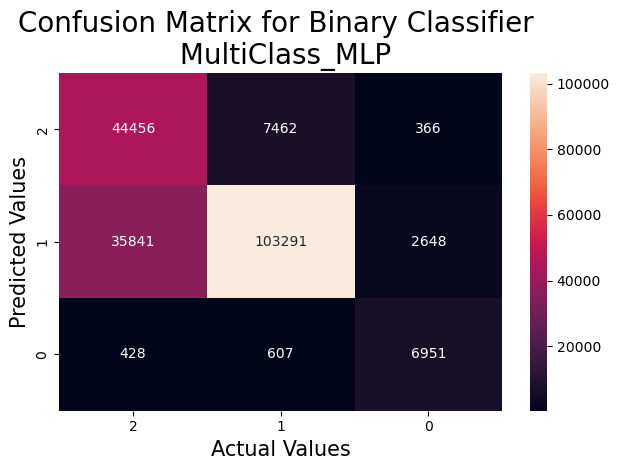

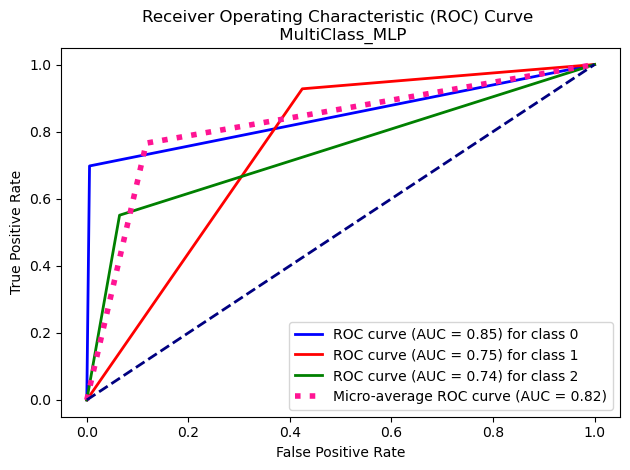

In [61]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test_list,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [62]:
# define a final dataframe to store the predictions
final_predictions_df = pd.DataFrame()

In [63]:
# make a df of the predictions and the true labels
y_pred_df = pd.DataFrame(y_pred_list, columns=["predicted_label"])
y_true_df = pd.DataFrame(Y_test_list, columns=["true_label"])
# concat the two dataframes
final_predictions_df = pd.concat([y_true_df, y_pred_df], axis=1)
y_pred_df = pd.concat([y_true_df, y_pred_df], axis=1)

In [64]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_test.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_test], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [65]:
y_pred_df["data_split"] = "test"

In [66]:
# save the y_pred_df to a parquet file if shuffle is set to False
if not SHUFFLE:
    # set path
    y_pred_df_path = pathlib.Path(
        f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/testing_single_cell_predictions.parquet"
    )
    # make path if it doesn't exist
    y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
    # save the dataframe
    y_pred_df.to_parquet(y_pred_df_path)

In [67]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)

In [68]:
confusion_matrix_df

,0,1,2
0,6951,607,428
1,2648,103291,35841
2,366,7462,44456


In [69]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [70]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,6951,607,428
healthy,2648,103291,35841
pyroptosis,366,7462,44456


In [71]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "testing"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [72]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [73]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "testing"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

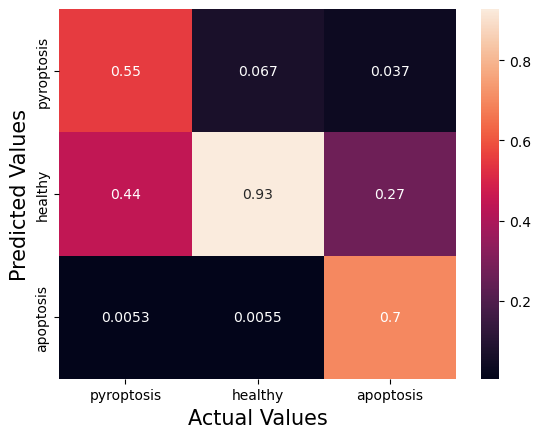

In [74]:
ax = sns.heatmap(confusion_matrix_df, annot=True)
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [75]:
stats_df = output_stats(
    y_pred_list,
    Y_test_list,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.87      0.70      0.77      9965
           1       0.73      0.93      0.82    111360
           2       0.85      0.55      0.67     80725

    accuracy                           0.77    202050
   macro avg       0.82      0.73      0.75    202050
weighted avg       0.78      0.77      0.76    202050



/tmp/ipykernel_2020721/3777910350.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [76]:
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_2020721/3610522228.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Test the treatment holdout data on the model

In [77]:
treatment_holdout_data = Dataset_formatter(
    X_treatment_holdout,
    Y_treatment_holdout,
)

# convert data class into a dataloader to be compatible with pytorch
treatment_holdout_loader = torch.utils.data.DataLoader(
    dataset=treatment_holdout_data, batch_size=1, shuffle=False
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    (y_pred_list, y_pred_prob_list, Y_test_list,) = test_optimized_model(
        model,
        treatment_holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        treatment_holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_treatment_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [78]:
# convert output tensors into arrays

# list of tensors to list of lists
y_pred_prob_list = [tensor.tolist() for tensor in y_pred_prob_list]
Y_test_list = [tensor.tolist() for tensor in Y_test_list]
# completly flatten list of lists
new_prob_list = []
for i in y_pred_prob_list:
    for j in i:
        new_prob_list.append(j)

new_y_test_list = []
for i in Y_test_list:
    for j in i:
        new_y_test_list.append(j)

# list of lists to array
y_pred_prob_list = np.array(new_prob_list)
Y_test = np.array(new_y_test_list)

In [79]:
# get the PR curve for each class
pr_curve_0 = precision_recall_curve(Y_test[:, 0], y_pred_prob_list[:, 0])
pr_curve_1 = precision_recall_curve(Y_test[:, 1], y_pred_prob_list[:, 1])
pr_curve_2 = precision_recall_curve(Y_test[:, 2], y_pred_prob_list[:, 2])

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [80]:
# make a dataframe of the precision-recall curves for each class
pr_curve_0 = pd.DataFrame(
    zip(pr_curve_0[0], pr_curve_0[1]),
    columns=["precision", "recall"],
)
pr_curve_0["label"] = 0

pr_curve_1 = pd.DataFrame(
    zip(pr_curve_1[0], pr_curve_1[1]),
    columns=["precision", "recall"],
)
pr_curve_1["label"] = 1

pr_curve_2 = pd.DataFrame(
    zip(pr_curve_2[0], pr_curve_2[1]),
    columns=["precision", "recall"],
)
pr_curve_2["label"] = 2

# make the precision-recall curve dataframe
pr_curve_df = pd.DataFrame(columns=["precision", "recall", "label"])
pr_curve_df = pd.concat([pr_curve_df, pr_curve_0, pr_curve_1, pr_curve_2])


# get the decoded labels
tmp_df = df_values[["new_labels", "labels"]]
# get the unique rows
tmp_df.drop_duplicates(inplace=True)
# make a dict of the labels and new labels
label_dict = dict(zip(tmp_df["new_labels"], tmp_df["labels"]))

# change the label column to the actual labels from the label dict
pr_curve_df["label"] = pr_curve_df["label"].map(label_dict)
pr_curve_df["data_split"] = "treatment_holdout"
pr_curve_df["shuffle"] = mlp_params.SHUFFLE

/tmp/ipykernel_2020721/1252073758.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop_duplicates(inplace=True)


In [81]:
# create a master dataframe to store all the model stats
# across all data splits and shuffled data
pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)

/tmp/ipykernel_2020721/2243255322.py:3: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)


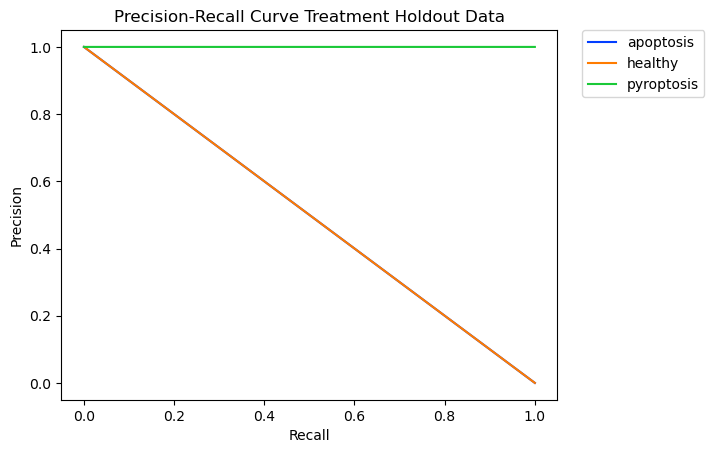

In [82]:
# plot the precision-recall curves
sns.lineplot(
    data=pr_curve_df,
    x="recall",
    y="precision",
    hue="label",
    palette="bright",
)
plt.title("Precision-Recall Curve Treatment Holdout Data")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [83]:
pr_curve_df_all["data_split"].unique()

array(['train', 'validation', 'testing', 'treatment_holdout'],
      dtype=object)

In [84]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["class_0_prob", "class_1_prob", "class_2_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "treatment_holdout"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)

main_prob_df = pd.concat([main_prob_df, prob_df])

/tmp/ipykernel_2020721/3006017747.py:23: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  main_prob_df = pd.concat([main_prob_df, prob_df])


In [85]:
Y_test_list = [np.argmax(i) for i in Y_test]

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       433
           1       0.00      0.00      0.00     37752
           2       0.30      1.00      0.46     16422

    accuracy                           0.30     54607
   macro avg       0.10      0.33      0.15     54607
weighted avg       0.09      0.30      0.14     54607

Precision for class 0: 0.0
Recall for class 0: 0.0
Precision for class 1: 0.0
Recall for class 1: 0.0


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Precision for class 2: 1.0
Recall for class 2: 0.3007306755544161
3


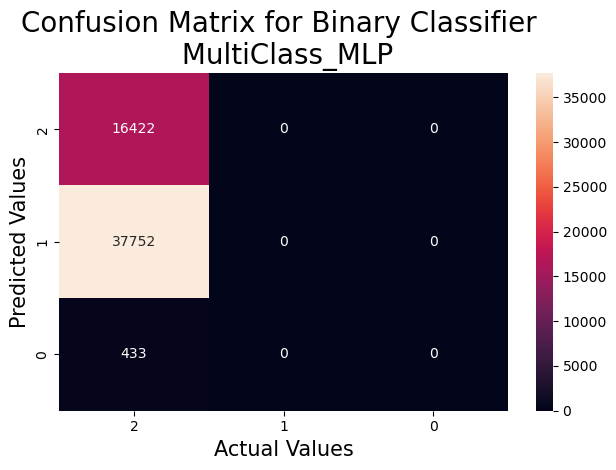

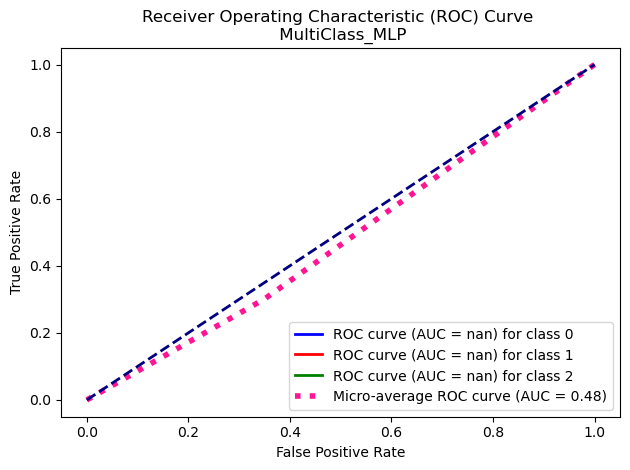

In [86]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test_list,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_treatment_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_treatment_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_treatment_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [87]:
confusion_matrix_df.T

,0,1,2
0,0,0,0
1,0,0,0
2,433,37752,16422


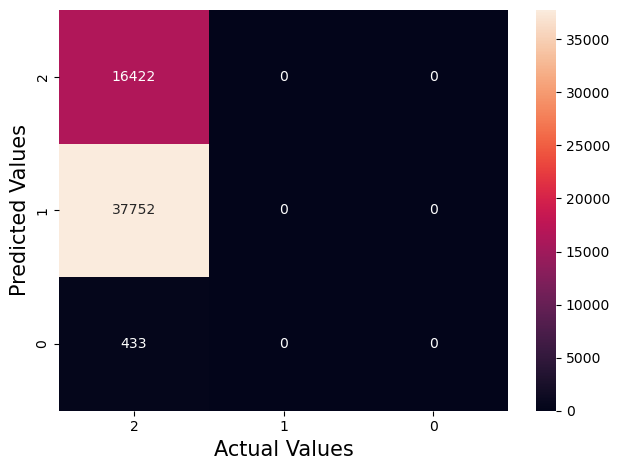

In [88]:
ax = sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
ax.invert_xaxis()
ax.invert_yaxis()
#
# plt.title(f"Confusion Matrix for Binary Classifier \n {title}", fontsize=20)
plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.tight_layout()
plt.show()

In [89]:
# make a df of the predictions and the true labels
y_pred_df = pd.DataFrame(y_pred_list, columns=["predicted_label"])
y_true_df = pd.DataFrame(Y_test_list, columns=["true_label"])
# concat the two dataframes
final_predictions_df = pd.concat([y_true_df, y_pred_df], axis=1)
y_pred_df = pd.concat([y_true_df, y_pred_df], axis=1)

In [90]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_treatment_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_treatment_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [91]:
y_pred_df["data_split"] = "treatment_holdout"
y_pred_df["shuffle"] = mlp_params.SHUFFLE
y_pred_df

,true_label,predicted_label,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,...,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split,shuffle
index,,,,,,,,,,,,,,,,,,,,,
93196,2,1,SH-SY5Y,D16,4344,6,DMSO,0.025,%,LPS,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,7,7,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,False
93197,2,1,SH-SY5Y,D16,4344,6,DMSO,0.025,%,LPS,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,2,2,8,8,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,False
93198,2,1,SH-SY5Y,D16,4344,6,DMSO,0.025,%,LPS,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,3,3,9,9,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,False
93199,2,2,SH-SY5Y,D16,4344,6,DMSO,0.025,%,LPS,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,4,4,12,12,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,False
93200,2,1,SH-SY5Y,D16,4344,6,DMSO,0.025,%,LPS,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,5,5,13,13,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594342,2,1,SH-SY5Y,N23,2963,6,Disulfiram,1.000,µM,Flagellin,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,89,89,93,93,Flagellin,1.000_µg_per_ml,pyroptosis,treatment_holdout,False
594343,2,1,SH-SY5Y,N23,2963,6,Disulfiram,1.000,µM,Flagellin,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,143,143,147,147,Flagellin,1.000_µg_per_ml,pyroptosis,treatment_holdout,False
594344,2,1,SH-SY5Y,N23,2963,6,Disulfiram,1.000,µM,Flagellin,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,173,173,178,178,Flagellin,1.000_µg_per_ml,pyroptosis,treatment_holdout,False


In [92]:
# set path for the model training metrics
y_pred_df_path = pathlib.Path(
    f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
y_pred_df_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
y_pred_file = pathlib.Path(
    f"{y_pred_df_path}/treatment_holdout_single_cell_predictions.parquet"
)
if y_pred_file.exists():
    y_pred_old = pd.read_parquet(y_pred_file)
    if len(y_pred_old["shuffle"].unique()) > 1:
        pass
    elif y_pred_old["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        pr_curve_df_old = pd.concat([y_pred_old, y_pred_df], axis=0)
        pr_curve_df_old.to_parquet(y_pred_file, index=False)
else:
    y_pred_df.to_parquet(y_pred_file, index=False)

In [93]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)

Do not do confusion matrix for this data as it is one class

In [94]:
stats_df = output_stats(
    y_pred_list,
    Y_test_list,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.30      0.46     54607

    accuracy                           0.30     54607
   macro avg       0.33      0.10      0.15     54607
weighted avg       1.00      0.30      0.46     54607



/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [95]:
stats_df["group"] = "treatment_holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_2020721/3703135615.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Test the hold out wells

In [96]:
holdout_data = Dataset_formatter(X_holdout, Y_holdout)

# convert data class into a dataloader to be compatible with pytorch
holdout_loader = torch.utils.data.DataLoader(
    dataset=holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    (y_pred_list, y_pred_prob_list, Y_test_list,) = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [97]:
# convert output tensors into arrays

# list of tensors to list of lists
y_pred_prob_list = [tensor.tolist() for tensor in y_pred_prob_list]
Y_test_list = [tensor.tolist() for tensor in Y_test_list]
# completly flatten list of lists
new_prob_list = []
for i in y_pred_prob_list:
    for j in i:
        new_prob_list.append(j)

new_y_test_list = []
for i in Y_test_list:
    for j in i:
        new_y_test_list.append(j)

# list of lists to array
y_pred_prob_list = np.array(new_prob_list)
Y_test = np.array(new_y_test_list)

In [98]:
# get the PR curve for each class
pr_curve_0 = precision_recall_curve(Y_test[:, 0], y_pred_prob_list[:, 0])
pr_curve_1 = precision_recall_curve(Y_test[:, 1], y_pred_prob_list[:, 1])
pr_curve_2 = precision_recall_curve(Y_test[:, 2], y_pred_prob_list[:, 2])

In [99]:
# make a dataframe of the precision-recall curves for each class
pr_curve_0 = pd.DataFrame(
    zip(pr_curve_0[0], pr_curve_0[1]),
    columns=["precision", "recall"],
)
pr_curve_0["label"] = 0

pr_curve_1 = pd.DataFrame(
    zip(pr_curve_1[0], pr_curve_1[1]),
    columns=["precision", "recall"],
)
pr_curve_1["label"] = 1

pr_curve_2 = pd.DataFrame(
    zip(pr_curve_2[0], pr_curve_2[1]),
    columns=["precision", "recall"],
)
pr_curve_2["label"] = 2

# make the precision-recall curve dataframe
pr_curve_df = pd.DataFrame(columns=["precision", "recall", "label"])
pr_curve_df = pd.concat([pr_curve_df, pr_curve_0, pr_curve_1, pr_curve_2])


# get the decoded labels
tmp_df = df_values[["new_labels", "labels"]]
# get the unique rows
tmp_df.drop_duplicates(inplace=True)
# make a dict of the labels and new labels
label_dict = dict(zip(tmp_df["new_labels"], tmp_df["labels"]))

# change the label column to the actual labels from the label dict
pr_curve_df["label"] = pr_curve_df["label"].map(label_dict)
pr_curve_df["data_split"] = "holdout"
pr_curve_df["shuffle"] = mlp_params.SHUFFLE

/tmp/ipykernel_2020721/3858670020.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop_duplicates(inplace=True)


In [100]:
# create a master dataframe to store all the model stats
# across all data splits and shuffled data
pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)

/tmp/ipykernel_2020721/2243255322.py:3: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)


In [101]:
pr_curve_df_all["data_split"].unique()

array(['train', 'validation', 'testing', 'treatment_holdout', 'holdout'],
      dtype=object)

In [102]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["class_0_prob", "class_1_prob", "class_2_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "holdout"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)

main_prob_df = pd.concat([main_prob_df, prob_df])

/tmp/ipykernel_2020721/3649338125.py:23: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  main_prob_df = pd.concat([main_prob_df, prob_df])


In [103]:
Y_test_list = [np.argmax(i) for i in Y_test]

              precision    recall  f1-score   support

           0       0.68      0.87      0.76      5510
           1       0.93      0.65      0.77    104214
           2       0.51      0.88      0.65     41177

    accuracy                           0.72    150901
   macro avg       0.71      0.80      0.72    150901
weighted avg       0.81      0.72      0.73    150901

Precision for class 0: 0.8669691470054447
Recall for class 0: 0.6777809307604994
Precision for class 1: 0.652263611414973
Recall for class 1: 0.9304760861828236
Precision for class 2: 0.8790829832187872
Recall for class 2: 0.5112784078871171
3


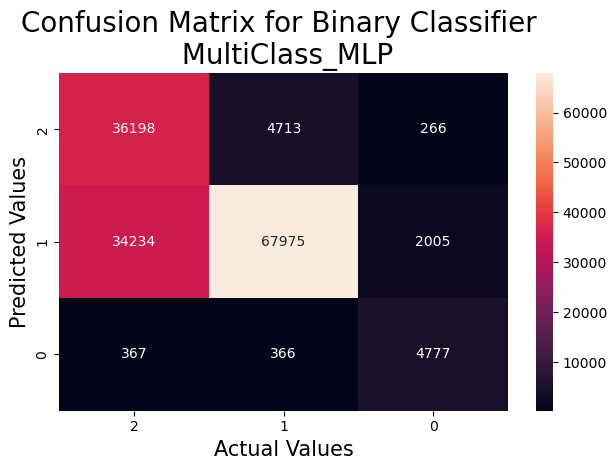

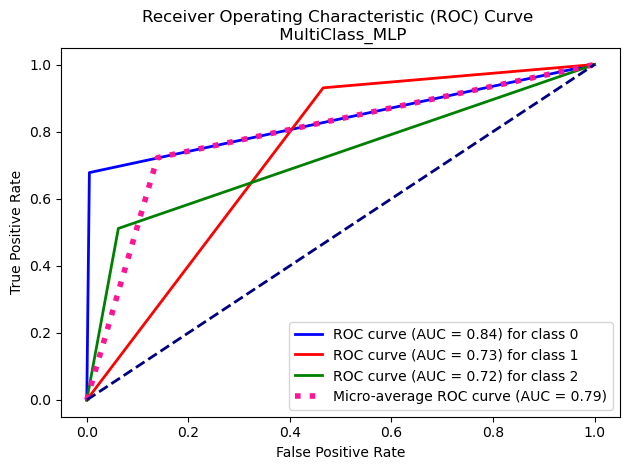

In [104]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test_list,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [105]:
# make a df of the predictions and the true labels
y_pred_df = pd.DataFrame(y_pred_list, columns=["predicted_label"])
y_true_df = pd.DataFrame(Y_test_list, columns=["true_label"])
# concat the two dataframes
final_predictions_df = pd.concat([y_true_df, y_pred_df], axis=1)
y_pred_df = pd.concat([y_true_df, y_pred_df], axis=1)

In [106]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [107]:
y_pred_df["data_split"] = "holdout"
y_pred_df["shuffle"] = mlp_params.SHUFFLE

In [108]:
y_pred_df

,true_label,predicted_label,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,...,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split,shuffle
index,,,,,,,,,,,,,,,,,,,,,
42557,1,1,SH-SY5Y,F14,4528,6,DMSO,0.025,%,Topotecan,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,2,2,Topotecan,5.000_nM,healthy,holdout,False
42558,1,1,SH-SY5Y,F14,4528,6,DMSO,0.025,%,Topotecan,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,2,2,6,6,Topotecan,5.000_nM,healthy,holdout,False
42559,1,1,SH-SY5Y,F14,4528,6,DMSO,0.025,%,Topotecan,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,3,3,8,8,Topotecan,5.000_nM,healthy,holdout,False
42560,1,1,SH-SY5Y,F14,4528,6,DMSO,0.025,%,Topotecan,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,4,4,9,9,Topotecan,5.000_nM,healthy,holdout,False
42561,1,1,SH-SY5Y,F14,4528,6,DMSO,0.025,%,Topotecan,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,5,5,10,10,Topotecan,5.000_nM,healthy,holdout,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584185,1,1,SH-SY5Y,K23,3367,6,Z-VAD-FMK,100.000,µM,H2O2,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,185,185,188,188,H2O2,100.000_µM,healthy,holdout,False
584186,1,1,SH-SY5Y,K23,3367,6,Z-VAD-FMK,100.000,µM,H2O2,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,2,2,7,7,H2O2,100.000_µM,healthy,holdout,False
584187,1,1,SH-SY5Y,K23,3367,6,Z-VAD-FMK,100.000,µM,H2O2,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,129,129,141,141,H2O2,100.000_µM,healthy,holdout,False


In [109]:
# set path for the model training metrics
y_pred_df_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
y_pred_df_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
y_pred_df_file = pathlib.Path(
    f"{y_pred_df_path}/holdout_single_cell_predictions.parquet"
)
if y_pred_df_file.exists():
    prediction_old = pd.read_parquet(y_pred_df_file)
    if len(prediction_old["shuffle"].unique()) > 1:
        pass
    elif prediction_old["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        probabilties_df_old = pd.concat([prediction_old, y_pred_df], axis=0)
        probabilties_df_old.to_parquet(y_pred_df_file, index=False)
else:
    y_pred_df.to_parquet(y_pred_df_file, index=False)

In [110]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,true_label,predicted_label,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,...,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split,shuffle
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584185,1,1,SH-SY5Y,K23,3367.0,6.0,Z-VAD-FMK,100.000,µM,H2O2,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,185.0,185.0,188.0,188.0,H2O2,100.000_µM,healthy,holdout,False
584186,1,1,SH-SY5Y,K23,3367.0,6.0,Z-VAD-FMK,100.000,µM,H2O2,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,2.0,2.0,7.0,7.0,H2O2,100.000_µM,healthy,holdout,False
584187,1,1,SH-SY5Y,K23,3367.0,6.0,Z-VAD-FMK,100.000,µM,H2O2,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,129.0,129.0,141.0,141.0,H2O2,100.000_µM,healthy,holdout,False
584188,1,1,SH-SY5Y,K23,3367.0,6.0,Z-VAD-FMK,100.000,µM,H2O2,...,*70117_20230210MM1_Gasdermin514_CP_BC430856,193.0,193.0,203.0,203.0,H2O2,100.000_µM,healthy,holdout,False


In [111]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [112]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [113]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [114]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [115]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_2020721/2372900873.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


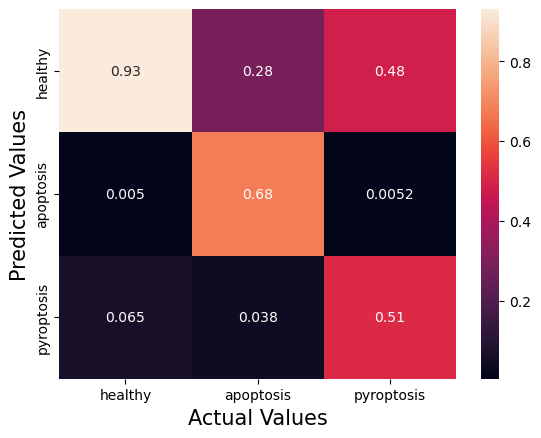

In [116]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [117]:
stats_df = output_stats(
    y_pred_list,
    Y_test_list,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.87      0.68      0.76      7048
           1       0.65      0.93      0.77     73054
           2       0.88      0.51      0.65     70799

    accuracy                           0.72    150901
   macro avg       0.80      0.71      0.72    150901
weighted avg       0.77      0.72      0.71    150901



/tmp/ipykernel_2020721/3777910350.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [118]:
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_2020721/3238046929.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


### Save Files

In [119]:
# set path for the model confusion matrices
predictions_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
predictions_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{predictions_path}/single_cell_predictions.parquet")
if matrix_file.exists():
    predictions_df_tmp = pd.read_parquet(matrix_file)
    if len(predictions_df_tmp["data_split"].unique()) > 1:
        pass
    elif predictions_df_tmp["data_split"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([predictions_df_tmp, final_predictions_df], axis=0)
        metrics_df.to_parquet(matrix_file, index=False)
else:
    final_predictions_df.to_parquet(matrix_file, index=False)

In [120]:
# set path for the model confusion matrices
matrix_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
matrix_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{matrix_path}/confusion_matrices.parquet")
if matrix_file.exists():
    metrics_df = pd.read_parquet(matrix_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, data_split_conf_mat_df_all], axis=0)
        metrics_df.to_parquet(matrix_file, index=False)
else:
    data_split_conf_mat_df_all.to_parquet(matrix_file, index=False)

In [121]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.parquet")
if metrics_file.exists():
    metrics_df = pd.read_parquet(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_parquet(metrics_file, index=False)
else:
    model_stats_df.to_parquet(metrics_file, index=False)

In [122]:
# set path for the model training metrics
pr_curve_file_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
pr_curve_file_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
pr_curve_file = pathlib.Path(f"{pr_curve_file_path}/PR_curves.parquet")
if pr_curve_file.exists():
    pr_curve_df_old = pd.read_parquet(pr_curve_file)
    if len(pr_curve_df_old["shuffle"].unique()) > 1:
        pass
    elif pr_curve_df_old["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        pr_curve_df_old = pd.concat([pr_curve_df_old, pr_curve_df_all], axis=0)
        pr_curve_df_old.to_parquet(pr_curve_file, index=False)
else:
    pr_curve_df_all.to_parquet(pr_curve_file, index=False)

In [123]:
# set path for the model training metrics
probabilties_df_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
probabilties_df_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
probabilties_df_file = pathlib.Path(f"{probabilties_df_path}/probabilities.parquet")
if probabilties_df_file.exists():
    probabilties_df_old = pd.read_parquet(probabilties_df_file)
    if len(probabilties_df_old["shuffle"].unique()) > 1:
        pass
    elif probabilties_df_old["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        probabilties_df_old = pd.concat([probabilties_df_old, main_prob_df], axis=0)
        probabilties_df_old.to_parquet(probabilties_df_file, index=False)
else:
    main_prob_df.to_parquet(probabilties_df_file, index=False)